# Prepare data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_df = pd.read_csv('../input/train.csv')
train_df.head()

In [ ]:
train_df['img_id'] = train_df.Image_Label.apply(lambda x: x.split('_')[0])
train_df['label'] = train_df.Image_Label.apply(lambda x: x.split('_')[-1])

In [ ]:
labels = ['Fish', 'Flower', 'Gravel', 'Sugar']
classes = {}

for label in labels:
    df = train_df[train_df.label == label].dropna()
    classes[label] = df.img_id.values

In [ ]:
from tqdm import tqdm
img_names = train_df.img_id.unique()
label_strings = {}

for img in tqdm(img_names):
    label_string = ''
    for label in labels:
        if img in classes[label]:
            label_string += f'{label} '
    label_strings[img] = label_string[:-1] 

In [ ]:
X = pd.DataFrame(list(label_strings.items()), columns=['img', 'label'])
X.to_csv('../input/train_classes_fastai.csv', index=False)

In [ ]:
from tqdm import tqdm
X = {}
for img in tqdm(train_df.img_id.unique()):
    y = np.zeros(4)
    x = {}
    for i, label in enumerate(labels):
        if img in classes[label]:
            x[label] = 1.
        else:
            x[label] = 0.
        X[img] = x            

In [ ]:
X = pd.DataFrame(X).T

In [ ]:
X.to_csv('../input/train_classes.csv')

# Classifier in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import albumentations as albu
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader,Dataset

plt.ion()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def get_img(name, image_dir='../input/resized_train'):
    return np.load(os.path.join(image_dir, name+'.npy'))


def get_training_augmentation():
    train_transform = [
        albu.CLAHE(p=1),
        albu.HorizontalFlip(p=0.0),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0, shift_limit=0.1, p=0.3, border_mode=0),
        albu.HueSaturationValue(p=0.5),
        albu.GridDistortion(p=0.5),
        albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        albu.Normalize()
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    train_transform = [
        albu.CLAHE(p=1),
    ]
    return albu.Compose(train_transform)

class CloudDataset(Dataset):
    def __init__(
        self,
        datatype = "train",
        img_ids = None,
        df = None,
        transforms = None, 
        preprocessing = None,
    ):
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.datatype = datatype
        self.df = df
    
    
    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        cols = ['Fish', 'Flower', 'Gravel', 'Sugar']
        label = self.df[self.df.img==image_name][cols].values        
        
        if self.datatype == 'test':
            #something
            return img, label   
                        
        img = get_img(image_name)
        augmented = self.transforms(image=img)
        img = augmented["image"]
        
        if self.preprocessing:
            pp = self.preprocessing(image=img)
            img = pp['image']
#         label.to(dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long, device=device).squeeze()
        return img.transpose(2, 0, 1), label

    def __len__(self):
        return len(self.img_ids)

In [3]:
df = pd.read_csv('../input/train_classes.csv')
df = df.rename(columns={'Unnamed: 0':'img'})
ids = df.img.values

In [4]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(ids, test_size=0.2)
print(len(train_ids))
print(len(valid_ids))

4436
1110


In [5]:
num_workers = 0
bs = 16
train_dataset = CloudDataset(datatype='train', 
                             img_ids=train_ids, df = df,
                             transforms = get_training_augmentation())
train_loader = DataLoader(train_dataset, batch_size=bs, 
                          shuffle=True, num_workers=num_workers)

val_dataset = CloudDataset(datatype='val', 
                             img_ids=valid_ids, df = df,
                             transforms = get_validation_augmentation())
val_loader = DataLoader(val_dataset, batch_size=bs, 
                          shuffle=True, num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 320, 640])
torch.float32
tensor([1, 1, 0, 0], device='cuda:0')
torch.int64


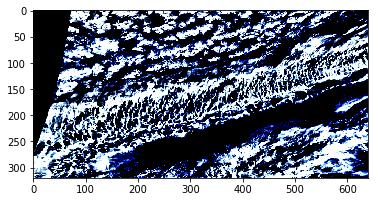

In [6]:
# Test dataloader
for x in train_loader:
    img = x[0][1]
    label = x[1][1]
    print(img.shape)
    print(img.dtype)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    print(label)
    print(label.dtype)
    break

# Define model

In [7]:
def get_model(num_classes, pretrained=True, freeze=True):
    model = models.resnet18(pretrained=pretrained)
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
            
    in_ftrs = model.fc.in_features
    model.fc = nn.Linear(in_ftrs, num_classes)
    return model

In [8]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
nc = 4
model = get_model(nc, pretrained=True, freeze=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
dataloaders = {'train':train_loader, 'val':val_loader}
num_epochs = 25


since = time.time()

val_acc_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))
    
model.load_state_dict(best_model_wts)

In [ ]:
outputs.shape

In [ ]:
labels.shape

In [ ]:
criterion(outputs, labels)